# Competition of RIDATSU prediction

In [35]:
import numpy as np

In [221]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [2]:
data_path = "/var/spool/data/hadoop-local/comp_ridatsu/"

In [3]:
import pandas as pd

In [4]:
users = pd.read_csv(data_path + "user.csv", header=None)
users[:2]

,0,1,2,3
0,81067,1,1,2015-01-11T11:09:20.239Z
1,149027,1,1,2015-01-12T21:31:16.722Z


In [5]:
train_data = pd.read_csv(data_path + "train.csv", header=None)

In [6]:
train_data[:2]

,0,1
0,176887,0
1,34795,0


In [7]:
test_data = pd.read_csv(data_path + "test.csv", header=None)

In [8]:
test_data[:2]

,0
0,36160
1,111951


In [9]:
for u_id in test_data.loc[:, 0]:
    if u_id not in users.loc[:, 0]:
        print u_id
for u_id in train_data.loc[:, 0]:
    if u_id not in users.loc[:, 0]:
        print u_id

> All train / test users are in users table

In [347]:
contents = pd.read_csv(data_path + "contents.csv", header=None, iterator=True, chunksize=1000)
contents.get_chunk()[:2]

,0,1,2
0,47472,6171978,2011-08-13T03:46:20.000Z
1,89301,3828557,2011-04-29T14:43:15.000Z


Features from contents:
 - number of contents

In [11]:
comments = pd.read_csv(data_path + "comments.csv", header=None)
comments[:2]

,0,1,2
0,43150,05223588,2014-04-03T07:53:20.259Z
1,43150,05223588,2014-04-03T08:32:56.718Z


Features from commments:
- Number of comments
- Number of commented

In [12]:
folders = pd.read_csv(data_path + "folder.csv", header=None)
folders[:2]

,0,1
0,6489,2014-05-23T05:00:01.083Z
1,6489,2014-05-23T06:24:17.128Z


Features from folder:
- Number of folders

In [325]:
visits = pd.read_csv(data_path + "visited.csv", header=None, iterator=True, chunksize=1000)
visits.get_chunk()[:2]

,0,1,2
0,6489,null,2013-07-10T07:56:29.486Z
1,57546,null,2013-07-10T07:58:36.617Z


Features from visited:
- number of visits
- total of visited contents of user

In [14]:
deletes = pd.read_csv(data_path + "deleted.csv", header=None)
deletes[:2]

,0,1
0,57379,2013-05-24T06:11:34.567Z
1,86100,2013-05-24T06:26:34.254Z


Features from deletes:
- number of deletes

---

### Naive features 1

In [15]:
from collections import defaultdict

content_user_map = {}
f_num_contents = defaultdict(int)

for u, cont, _  in contents.values:
    f_num_contents[u] += 1
    content_user_map[cont] = u

In [17]:
f_num_comments = defaultdict(int)
f_num_commented = defaultdict(int)

for u, cont, _ in comments.values:
    if cont in content_user_map:
        cont_u = content_user_map[cont]
        f_num_commented[cont_u] += 1
    f_num_comments[u] += 1

In [18]:
f_num_folders = defaultdict(int)

for u, _ in folders.values:
    f_num_folders[u] += 1

In [20]:
f_num_visits = defaultdict(int)
f_num_visited = defaultdict(int)

for u, cont, _ in visits.values:
    if cont in content_user_map:
        cont_u = content_user_map[cont]
        f_num_visited[cont_u] += 1
    f_num_visits[u] += 1

In [21]:
f_num_deletes = defaultdict(int)

for u, _ in deletes.values:
    f_num_deletes[u] += 1

logistic regression

In [58]:
import random
rand = random.Random(3)

def get_feature(u):
    feature = [f_num_contents[u], f_num_comments[u], f_num_commented[u], f_num_deletes[u], f_num_folders[u], f_num_visits[u], f_num_visited[u]]
    return feature
    
train_pairs = []
for u, target in train_data.values:
    train_pairs.append((u, target))
rand.shuffle(train_pairs)

features = []
targets = []
test_features = []
for u, target in train_pairs:
    features.append(get_feature(u))
    targets.append(target)
    
for u, in test_data.values:
    test_features.append(get_feature(u))

In [107]:
# Normalize features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
features = np.array(features, dtype="float32")
truncated_features = (features < features.std(axis=0)) * features + (features >= features.std(axis=0)) * (features.std(axis=0))
norm = StandardScaler()
norm_features = norm.fit_transform(truncated_features)

In [109]:
valid_size = 500
train_xs = norm_features[valid_size:]
train_ys = targets[valid_size:]
valid_xs = norm_features[:valid_size]
valid_ys = targets[:valid_size]

In [110]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
lr = LogisticRegression()
lr.fit(train_xs, train_ys)
valid_yhat = lr.predict_proba(valid_xs)[np.arange(len(valid_ys)), 1]
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_yhat, pos_label=1)
print "prec:", lr.score(valid_xs, valid_ys)
print "auc:", metrics.auc(fpr, tpr)

prec: 0.676
auc: 0.703212682379


make submission

In [62]:
test_yhat = lr.predict_proba(test_features)[np.arange(len(test_features)), 1]
with open("/tmp/submission_lr1.csv", "w") as outf:
    for u, prob in zip([t[0] for t in test_data.values], test_yhat):
        print >> outf, "%d,%f" % (u, prob)

random forest

In [112]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(random_state=3, n_estimators=1000, n_jobs=-1)
rfc.fit(train_xs, train_ys)
valid_yhat = rfc.predict_proba(valid_xs)[np.arange(len(valid_ys)), 1]
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_yhat, pos_label=1)
print "prec:", lr.score(valid_xs, valid_ys)
print "auc:", metrics.auc(fpr, tpr)

prec: 0.676
auc: 0.661563552189


ensemble of rfc and lr

In [113]:
valid_ens_lr_rfc = (rfc.predict_proba(valid_xs)[np.arange(len(valid_xs)), 1] + lr.predict_proba(valid_xs)[np.arange(len(valid_xs)), 1]) / 2
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_ens_lr_rfc, pos_label=1)
print "auc:", metrics.auc(fpr, tpr)

auc: 0.684974747475


In [319]:
%xdel f_num_contents
%xdel f_num_visits
%xdel f_num_commented
%xdel f_num_comments
%xdel f_num_folders
%xdel f_num_deletes

NameError: name 'f_num_contents' is not defined


### 2. Time weighed features

In [114]:
ROD = 0.95

In [130]:
import datetime 
end_date = datetime.datetime(2015, 2, 20)
end_date

datetime.datetime(2015, 2, 20, 0, 0)

In [150]:
from collections import defaultdict

content_user_map = {}
f2_num_contents = defaultdict(int)

for u, cont, date  in contents.values:
    date = dateutil.parser.parse(date).replace(tzinfo=None)
    date_diff = (end_date - date).days
    f2_num_contents[u] += ROD ** date_diff
    content_user_map[cont] = u

In [151]:
f2_num_comments = defaultdict(int)
f2_num_commented = defaultdict(int)

for u, cont, date in comments.values:
    date = dateutil.parser.parse(date).replace(tzinfo=None)
    date_diff = (end_date - date).days
    if cont in content_user_map:
        cont_u = content_user_map[cont]
        f2_num_commented[cont_u] += ROD ** date_diff
    f2_num_comments[u] += ROD ** date_diff

In [152]:
f2_num_folders = defaultdict(int)

for u, date in folders.values:
    date = dateutil.parser.parse(date).replace(tzinfo=None)
    date_diff = (end_date - date).days
    f2_num_folders[u] += ROD ** date_diff

In [153]:
f2_num_visits = defaultdict(int)
f2_num_visited = defaultdict(int)

for u, cont, date in visits.values:
    date = dateutil.parser.parse(date).replace(tzinfo=None)
    date_diff = (end_date - date).days
    if cont in content_user_map:
        cont_u = content_user_map[cont]
        f2_num_visited[cont_u] += ROD ** date_diff
    f2_num_visits[u] += ROD ** date_diff

In [144]:
f2_num_deletes = defaultdict(int)

for u, date in deletes.values:
    date = dateutil.parser.parse(date).replace(tzinfo=None)
    date_diff = (end_date - date).days
    f2_num_deletes[u] += ROD ** date_diff

train

In [154]:
import random
rand = random.Random(3)

def get_feature(u):
    feature = [f2_num_contents[u], f2_num_comments[u], f2_num_commented[u], f2_num_deletes[u], f2_num_folders[u], f2_num_visits[u], f2_num_visited[u]]
    return feature
    
train_pairs = []
for u, target in train_data.values:
    train_pairs.append((u, target))
rand.shuffle(train_pairs)

features = []
targets = []
test_features = []
for u, target in train_pairs:
    features.append(get_feature(u))
    targets.append(target)
    
for u, in test_data.values:
    test_features.append(get_feature(u))

In [268]:
# Normalize features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
features = np.array(features, dtype="float32")
truncated_features = (features < features.std(axis=0)) * features + (features >= features.std(axis=0)) * (features.std(axis=0))
norm = StandardScaler()
norm_features = norm.fit_transform(truncated_features)
valid_size = 500
train_xs = norm_features[valid_size:]
train_ys = targets[valid_size:]
valid_xs = norm_features[:valid_size]
valid_ys = targets[:valid_size]
test_xs = norm.transform(test_features)

In [269]:
# lr
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
lr = LogisticRegression()
lr.fit(train_xs, train_ys)
valid_yhat = lr.predict_proba(valid_xs)[np.arange(len(valid_ys)), 1]
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_yhat, pos_label=1)
print "prec:", lr.score(valid_xs, valid_ys)
print "auc:", metrics.auc(fpr, tpr)

prec: 0.716
auc: 0.749649270483


In [251]:
# Submit
test_yhat = lr.predict_proba(test_xs)[np.arange(len(test_xs)), 1]
with open("/tmp/submission_tw_lr2.csv", "w") as outf:
    for u, prob in zip([t[0] for t in test_data.values], test_yhat):
        print >> outf, "%d,%f" % (u, prob)

In [174]:
# Random forest
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(random_state=3, n_estimators=1000, n_jobs=-1)
rfc.fit(train_xs, train_ys)
valid_yhat = rfc.predict_proba(valid_xs)[np.arange(len(valid_ys)), 1]
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_yhat, pos_label=1)
print "prec:", rfc.score(valid_xs, valid_ys)
print "auc:", metrics.auc(fpr, tpr)

prec: 0.652
auc: 0.662326388889


In [178]:
# SVM
from sklearn.svm import SVC 
svc = SVC(probability=True, random_state=3)
svc.fit(train_xs, train_ys)
valid_yhat = svc.predict_proba(valid_xs)[np.arange(len(valid_ys)), 1]
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_yhat, pos_label=1)
print "prec:", svc.score(valid_xs, valid_ys)
print "auc:", metrics.auc(fpr, tpr)

prec: 0.74
auc: 0.730429292929


### Ensemble

In [303]:
# Ensemble of LR and SVC
def ensemble(prob_matrix, weights, valid_targets=None):
    denom = sum(weights)
    weights = np.array(weights, dtype="float32")[:, None]
    probs = (prob_matrix * weights).sum(axis=0) / denom
    if valid_targets:
        fpr, tpr, _ = metrics.roc_curve(valid_ys, probs, pos_label=1)
        return metrics.auc(fpr, tpr)
    else:
        return probs

svc_probs = svc.predict_proba(valid_xs)[np.arange(len(valid_xs)), 1]
lr_probs = lr.predict_proba(valid_xs)[np.arange(len(valid_xs)), 1]
prob_matrix = [svc_probs, lr_probs]

In [304]:
print "auc:", ensemble(prob_matrix, weights=[1, 1], valid_targets=valid_ys)

auc: 0.752981200898


find the best ensemble weight

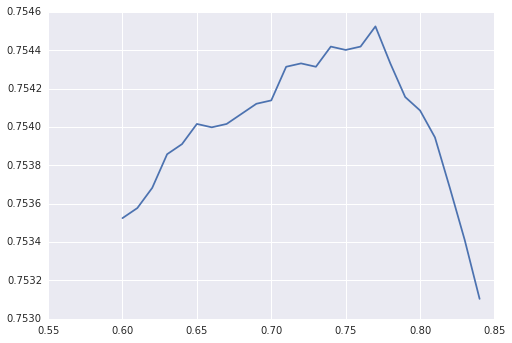

0.77000000000000013

In [244]:
X_search = np.arange(0.6, 0.85, 0.01)
AUC_search = [ensemble(prob_matrix, weights=[x, 1-x], valid_targets=valid_ys) for x in X_search]
plt.plot(X_search, AUC_search)
plt.show()
X_search[np.array(AUC_search).argmax()]

In [278]:
# Submit
svc_testprobs = svc.predict_proba(test_xs)[np.arange(len(test_xs)), 1]
lr_testprobs = lr.predict_proba(test_xs)[np.arange(len(test_xs)), 1]
prob_matrix = [svc_testprobs, lr_testprobs]
test_yhat = ensemble(prob_matrix, weights=[1, 1])
with open("/tmp/submission_tw_ensLRSVC_11.csv", "w") as outf:
    for u, prob in zip([t[0] for t in test_data.values], test_yhat):
        print >> outf, "%d,%f" % (u, prob)

### TODO: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/forums/t/14628/share-your-secret-sauce --> Done

### Hyperopt hpsklearn: https://github.com/hyperopt/hyperopt-sklearn/blob/master/notebooks/skdata_quick_intro.ipynb

### PCA

### XGBOOST https://github.com/dmlc/xgboost

In [285]:
sys.path.append("/home/hadoop/apps/xgboost/wrapper")
import xgboost as xgb

In [288]:
dtrain = xgb.DMatrix(train_xs, label=train_ys)
dvalid = xgb.DMatrix(valid_xs, label=valid_ys)

In [ ]:
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
plst = param.items()
plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
evallist  = [(dvalid,'valid'), (dtrain,'train')]
num_round = 44
bst = xgb.train( plst, dtrain, num_round, evallist )

In [310]:
dt_valid = xgb.DMatrix( valid_xs, missing = -999.0 )
valid_yhat = bst.predict(dt_valid)
xgb_probs = valid_yhat
fpr, tpr, _ = metrics.roc_curve(valid_ys, valid_yhat, pos_label=1)
print "auc:", metrics.auc(fpr, tpr)

auc: 0.765589927048


In [302]:
dtest = xgb.DMatrix(test_xs, missing = -999.0 )
xgb_test_yhat = bst.predict(dtest)
with open("/tmp/submission_tw_xgb1.csv", "w") as outf:
    for u, prob in zip([t[0] for t in test_data.values], xgb_test_yhat):
        print >> outf, "%d,%f" % (u, prob)

In [312]:
xgb_probs.shape

(500,)

In [313]:
prob_matrix = [xgb_probs, lr_probs]
print "auc:", ensemble(prob_matrix, weights=[1, 1], valid_targets=valid_ys)

auc: 0.760451739618


In [349]:
# sumbit ensemble of xgb and lr
test_yhat = ensemble([xgb_test_yhat, lr_testprobs], weights=[1, 1])
with open("/tmp/submission_tw_ensLRXGB_11.csv", "w") as outf:
    for u, prob in zip([t[0] for t in test_data.values], test_yhat):
        print >> outf, "%d,%f" % (u, prob)

### TODO: DEEPY

### More features:
> get from it https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/forums/t/14628/share-your-secret-sauce/81309#post81309

- mean time of ...
- entropy 
- mean of visits per content for a user
- avg, max, min num of contents in a day
- average comments per content for a user
- date that user registered

Create data with date

In [340]:
import csv

def replace_row(row):
    date = row[-1]
    date = dateutil.parser.parse(date).replace(tzinfo=None)
    date_diff = (end_date - date).days
    row[-1] = date_diff
    return row

def replace_date_to_csv(table, fp, chunk=False):
    with open(fp, "wb") as out_csvf:
        writer = csv.writer(out_csvf)
        if chunk:
            for chunk in table:
                for row in chunk.values:
                    writer.writerow(replace_row(row))
        else:
            for row in table.values:
                writer.writerow(replace_row(row))

In [333]:
replace_date_to_csv(users, data_path + "users_date.csv")

In [335]:
replace_date_to_csv(folders, data_path + "folders_date.csv")

In [337]:
replace_date_to_csv(deletes, data_path + "deletes_date.csv")

In [ ]:

replace_date_to_csv(visits, data_path + "visits_date.csv", chunk=True)

In [ ]:
replace_date_to_csv(contents, data_path + "contents_date.csv", chunk=True)

### 3. More features